COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [1]:
# install dependencies
!rm -r Neural_Networks-101-demo
!git clone -b explanations https://github.com/KiranArun/Neural_Networks-101-demo.git
!python3 /content/Neural_Networks-101-demo/scripts/setup.py helper_funcs

Cloning into 'Neural_Networks-101-demo'...
remote: Counting objects: 352, done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 352 (delta 30), reused 57 (delta 14), pack-reused 271
Receiving objects: 100% (352/352), 7.53 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Getting helper functions...


# MNIST Handwritten Digits Classifier

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor
import helper_funcs as helper

In [0]:
model_root_dir = '/content/'

In [0]:
image_dims = (28,28)
input_size = 28**2
num_classes = 10

In [0]:
class classifier():
    
    def __init__(self, layers):
        
        self.mnist = helper.MNIST_data(model_root_dir+'MNIST_data/')
        
        layers += [num_classes]
        self.layers = layers
        
        self._init_weights()
        self._init_biases()
        
    def _init_weights(self):
        
        self.Weights = []

        for layer in self.layers:

            if len(self.Weights) == 0:
                self.Weights += [np.random.randn(input_size,layer)]

            else:
                self.Weights += [np.random.randn(self.Weights[-1].shape[-1],layer)]
                
    def _init_biases(self):
        
        self.biases = []
        
        for layer in self.layers:
            
            self.biases += [np.random.randn(layer)]
            
            
            
            
    def activation(self,x):
        
        x[x<0] = 0.0
        
        return(x)
    
    def activation_prime(self,x):
        
        x[x<0] = 0.0
        x[x>0] = 1.0
        
        return(x)
        
        
        
        
    def forward_pass(self,x):
        
        inputs_to_layers = []
        inputs_to_activations = []
        
        for layer in range(len(self.layers)):
            
            inputs_to_layers += [x]
            
            x = np.matmul(x,self.Weights[layer]) + self.biases[layer]
            
            if layer+1 != len(self.layers):
                
                inputs_to_activations += [x]
                
                x = self.activation(x)

        return(x,inputs_to_layers,inputs_to_activations)
    
    
    
    def softmax(self,x):
        
        x = x - np.max(x,axis=1,keepdims=True)
        
        output = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        
        return(output)
    
    
    
    def cross_entropy(self,labels,logits):

        labels = labels.reshape(-1,num_classes)
        logits = logits.reshape(-1,num_classes)
        
        losses = -np.sum(labels*np.log(np.clip(logits,1e-10,1)), axis=1)

        loss = np.mean(losses)

        return(loss)
    
    
    
    def back_prop(self,softmax_outputs,labels,learning_rate,layer_inputs,activation_inputs):

        batch_size = labels.shape[0]

        grads = softmax_outputs - labels
        
        for layer in range(len(self.layers)-1,-1,-1):
            
            if layer != len(self.layers)-1:
                
                grads = grads*self.activation_prime(activation_inputs[layer])

            W_deltas = np.matmul(layer_inputs[layer].transpose(),grads)
            b_deltas = np.sum(grads,axis=0)
            
            grads = np.matmul(grads,self.Weights[layer].transpose())
            
            W_deltas /= batch_size
            b_deltas /= batch_size
            
            self.Weights[layer] -= learning_rate*W_deltas
            self.biases[layer] -= learning_rate*b_deltas
            
            
            
            
    def calculate_accuracy(self,images,labels):
        
        logits = self.forward_pass(images)[0]
        labels = labels
        
        marking = np.equal(np.argmax(logits,axis=1),np.argmax(labels,axis=1))
        return(np.mean(marking.astype(np.int32)))
    
    
    
    
    def train(self,batch_size,learning_rate,epochs,reset):
        
        if reset == True:
            self._init_weights()
            self._init_biases()
        
        self.losses = np.array([])

        iterations = ceil(self.mnist.number_train_samples/batch_size)
        
        for epoch in range(epochs):
            print('New epoch', str(epoch+1)+'/'+str(epochs))
            for iteration in range(iterations):

                X,Y = self.mnist.get_batch(iteration,batch_size)

                nn_out,layer_inputs,activation_inputs = self.forward_pass(X)
                soft_out = self.softmax(nn_out)
                ce_out = self.cross_entropy(Y,soft_out)

                self.back_prop(soft_out,Y,learning_rate,layer_inputs,activation_inputs)

                if (iteration+1) % floor(iterations/5) == 0:

                    accuracy = self.calculate_accuracy(self.mnist.validation_images,self.mnist.validation_labels)

                    print('step', str(iteration+1)+'/'+str(iterations), 'loss', ce_out, 'accuracy', str(round(100*accuracy,2))+'%')

                self.losses = np.append(self.losses, ce_out)
                
    def plot_losses(self):
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(self.losses)
        ax.grid(True)

In [9]:
Model = classifier(layers=[256])

Download complete.
Save complete.


New epoch 1/2
step 110/550 loss 2.765637763746599 accuracy 86.78%
step 220/550 loss 1.3039781717564412 accuracy 90.12%
step 330/550 loss 0.9999157269324609 accuracy 91.22%
step 440/550 loss 1.3363032266164347 accuracy 91.48%
step 550/550 loss 1.3266665202838244 accuracy 92.6%
New epoch 2/2
step 110/550 loss 1.20474801966636 accuracy 92.5%
step 220/550 loss 0.17718511710179963 accuracy 92.66%
step 330/550 loss 0.5895994434750305 accuracy 92.72%
step 440/550 loss 0.8697018221077625 accuracy 93.32%
step 550/550 loss 1.0630739790612076 accuracy 93.4%
91.66


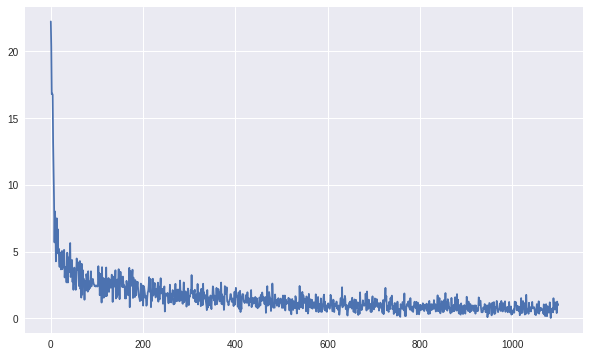

In [10]:
Model.train(batch_size=100,
            learning_rate=0.2,
            epochs=2,
            reset=True)

Model.plot_losses()

print(100*Model.calculate_accuracy(Model.mnist.test_images,Model.mnist.test_labels))